# Imports and Paths

In [1]:
import os
# import pandas as pd
import sys
# import numpy as np
from sklearn.ensemble import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
PATH_base = '/home/bj/git/data_science/'
PATH_bd = '/data/blue_book/'
PATH_func = PATH_base + 'src/'

In [3]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
elif os.name == 'posix':
    PATH_base = '/home/msnow/git/data_science/'
    PATH_bd = '/data/msnow/data_science/blue_book_for_bulldozers/'
    PATH_func = PATH_base + 'src/'

In [6]:
sys.path.append(PATH_func)

In [8]:
from features.imports import *
from features.utilities import *
from features.fastai import *


In [10]:
%ls ..\\data\\uncompressed\\blue_book_for_bulldozers\\

 Volume in drive E is Storage
 Volume Serial Number is D098-4C8A

 Directory of E:\GitHub\data_science\data\uncompressed\blue_book_for_bulldozers

03/24/2018  04:37 PM    <DIR>          .
03/24/2018  04:37 PM    <DIR>          ..
01/24/2013  09:08 PM       116,403,970 Train.csv
01/24/2013  07:11 PM         3,318,969 Valid.csv
               2 File(s)    119,722,939 bytes
               2 Dir(s)  1,852,864,679,936 bytes free


# Initial Data Munging

This dataset is from the kaggle competition [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers).  

In [23]:
df_raw = pd.read_csv(f'{PATH_bd}Train.csv', low_memory=False, parse_dates=["saledate"],nrows=50000)

In [10]:
# df_raw.to_feather(f'{PATH_bd}bulldozer_raw')
# df_orig = df_raw.copy()
# df_raw = df_orig

In [11]:
display_some(df_raw.head().T,80,10)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## Metrics

In this competition, the goal is to predict the SalePrice and the metric used is the root mean squared log error (RMSLE).  Therefore, I will convert the SalePrice column into the log of the SalePrice

In [24]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Splitting Datetime

Split the dattime column `saledate` into multiple columns containing integer components of the datetime, e.g., year, month, day, day of week, weekend

In [25]:
add_datepart(df_raw, 'saledate')

## Convert Strings to Integer Categorical 

Convert all columns with string values to integer categorical variables

In [26]:
train_cats(df_raw)

In [27]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

When there is ordinality in the strings you can assign the categorical integer values to share that order

In [28]:
df_codes = df_raw.UsageBand.cat.codes
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [29]:
df_UsageBand_cat = pd.DataFrame({'Raw':df_raw.UsageBand, 'Unordered':df_codes, 'Ordered':df_raw.UsageBand.cat.codes})
df_UsageBand_cat.head()

,Ordered,Raw,Unordered
0,2,Low,1
1,2,Low,1
2,0,High,0
3,0,High,0
4,1,Medium,2


In [30]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

## Save to/Load from Feather

In [6]:
# df_raw.to_feather(f'{PATH_base}\\data\\interim\\bulldozer')
df_raw = pd.read_feather(f'{PATH_base}\\data\\interim\\bulldozer')

# Random Forest

## $r^2$ and RMSE

In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9824105402447549

This score is the $r^2$ which is defined as :

$$r^2 = 1-\dfrac{SS_{res}}{SS_{tot}}  = 1-\dfrac{\sum\limits_i\left(y_i-f_i\right)^2}{\sum\limits_i\left(y_i-\bar{y}\right)^2}$$

where $y_i$ is the true output, $f_i$ is the model output and $\bar{y}$ is the mean true output.  Intepretation of different $r^2$ values is as follows
  1. $r^2 = 1$ means that the model perfectly predicts the output
  1. $r^2 = 0$ means the model does no better than predicting the output using the mean output, i.e., $\bar{y}$
  1. $1 > r^2 > 0 $ means that the model is better than simply using the mean ouptut
  1. $r^2 < 0$ means that the model is worse than just using the mean output as a predictor
 
However, $r^2$ by itself, is not a good metric as an overfit model will have an $r^2$ close to 1 for the training set, but would do much worse on a test set. 

To overcome the issue of overfitting, we can split the data into a training and validation set; using the training set to build the model and the validation set to test how good the model does on a different set of data.

In [32]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)

X_train.shape, y_train.shape, X_valid.shape

((38000, 65), (38000,), (12000, 65))

In [33]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09349769556571906
Validation rmse: 0.0688803687875353
Training Score: 0.9834323702372217
Validation Score: 0.9718148732063945


## Speeding Things Up

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);

In [36]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09821146385156575
Validation rmse: 0.1408816580112238
Training Score: 0.9781615564366094
Validation Score: 0.8820934386314245


In [37]:
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')

## Single Tree

In [49]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.4597788411499347
Validation rmse: 0.3319100874784081
Training Score: 0.521375113006602
Validation Score: 0.34555979942643605


In [53]:
export_graphviz(m.estimators_[0],out_file=None,feature_names=df_trn.columns,filled=True,

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 925932642,
 'splitter': 'best'}

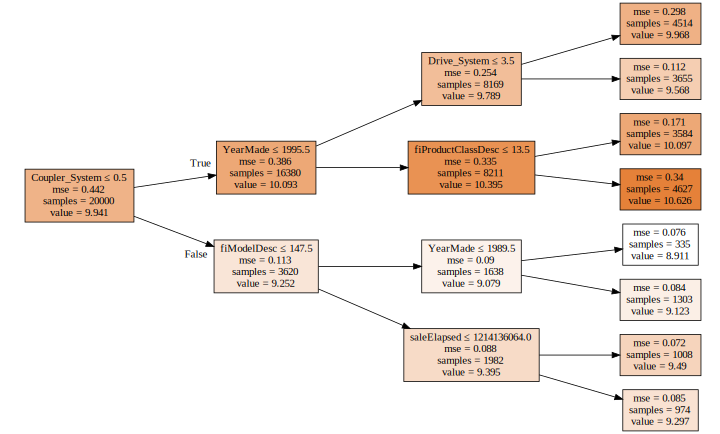

In [39]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### Interpreting the Decision Tree

If I took the mean output of my entire dataset and used that to predict the output for each individual observation, what would the mean square error be?

In [40]:
mse = ((y_train - y_train.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train)}')
print(f'mean value = {round(y_train.mean(),3)}')

mean square error = 0.442
samples = 20000
mean value = 9.941


Taking a look at the tree above, we can now see that the `values` and `mse` term of the first box correspond to the mean output value and mean squared error using the output value of the entire dataset. Let's see if this analysis holds true for the next couple of boxes.

In [41]:
y_train_2_1 = y_train[list(X_train.Coupler_System <= 0.5)]
mse = ((y_train_2_1 - y_train_2_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_1)}')
print(f'mean value = {round(y_train_2_1.mean(),3)}')

mean square error = 0.386
samples = 16380
mean value = 10.093


In [42]:
y_train_2_2 = y_train[list(X_train.Coupler_System > 0.5 )]
mse = ((y_train_2_2 - y_train_2_2.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_2)}')
print(f'mean value = {round(y_train_2_2.mean(),3)}')

mean square error = 0.113
samples = 3620
mean value = 9.252


In [43]:
y_train_3_1 = y_train[list((X_train.Coupler_System <= 0.5)  & (X_train.YearMade <= 1991.5))]
mse = ((y_train_3_1 - y_train_3_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_3_1)}')
print(f'mean value = {round(y_train_3_1.mean(),3)}')

mean square error = 0.254
samples = 6749
mean value = 9.737


## Bagging

The problem with using a single tree is that the smaller the leaf nodes are, the more overfit the model is.  When the leaf nodes only have a single value in them, the model is perfectly predicts the training set but does not score nearly as high on the validation set

In [46]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 2.3874896000997127e-06
Validation rmse: 0.17997538860410744
Training Score: 0.9999999999870944
Validation Score: 0.8075777425128688


In [45]:
m = RandomForestRegressor(n_estimators=1, max_depth=20, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.051060578487003024
Validation rmse: 0.1817210929663896
Training Score: 0.9940970544696073
Validation Score: 0.8038267685733541


To go from single decision trees to a random forest, you want to somehow combine multiple decision trees to end up with a result that is somehow better than any single decision tree.  This act of combining models to get a better model is called ensembling.  For the random forest, the idea being that you create lots of "bad" decision trees, where each one does contain some insight about your data as well as significantly overfitting the data (high score on training set, low score on validation set).  If you repeat this with lots of uncorrelated trees then their overfitting errors, which are randomly distributed, should average to zero, while retaining each individual tree's true information.

To uncorrelate the data we can randomly choose a subset of the data for each decision tree.

Lucky for us this is what scikit-learn does by default (this is the bootstrap parameter in the RandomForestRegressor (RFR)).  Technically, the RFR, picks out n_rows with replacement.

In [60]:
m = RandomForestRegressor(n_estimators=3, max_depth=2, bootstrap=True, n_jobs=-1, max_features=0.5)
m.fit(X_train, y_train);

In [82]:
X_pred0 = X_samp[['Coupler_System','YearMade','fiModelDesc']].copy()
X_pred0['prediction'] = np.round(preds[0,:],3)
X_pred0

,Coupler_System,YearMade,fiModelDesc,prediction
41307,0,1989,617,9.753
38621,0,1989,647,9.753
48595,0,1997,625,10.365


In [ ]:
# X_samp = X_valid.sample(3)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])
np.round(preds,3)

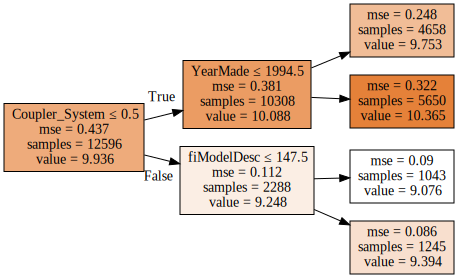

In [61]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [83]:
X_pred1 = X_samp[['ProductGroupDesc','fiProductClassDesc','YearMade']].copy()
X_pred1['prediction'] = np.round(preds[1,:],3)
X_pred1

,ProductGroupDesc,fiProductClassDesc,YearMade,prediction
41307,1,2,1989,9.850
38621,6,58,1989,9.921
48595,1,2,1997,9.850


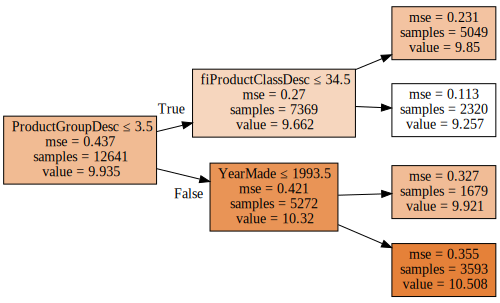

In [62]:
draw_tree(m.estimators_[1], df_trn, precision=3)

In [84]:
X_pred2 = X_samp[['Coupler_System','fiProductClassDesc','MachineHoursCurrentMeter']].copy()
X_pred2['prediction'] = np.round(preds[2,:],3)
X_pred2

,Coupler_System,fiProductClassDesc,MachineHoursCurrentMeter,prediction
41307,0,2,2628.0,9.779
38621,0,58,4058.0,10.363
48595,0,2,2628.0,9.779


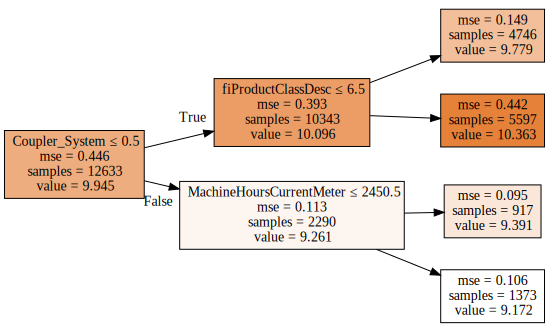

In [63]:
draw_tree(m.estimators_[2], df_trn, precision=3)

In [89]:
(10.363+9.921+9.793)/3

10.025666666666666

In [90]:
m.predict(X_samp.round(3))

array([ 9.79413645, 10.01224551,  9.99818403])

In [77]:
# X_samp = X_valid.sample(3)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])
np.round(preds,3)
# m.predict(X_samp)

array([[ 9.753,  9.753, 10.365],
       [ 9.85 ,  9.921,  9.85 ],
       [ 9.779, 10.363,  9.779]])

In [70]:
m.predict(X_samp)

array([9.79413645, 9.99818403, 9.79413645])

In [47]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.09602238815318566
Validation rmse: 0.14264384447581016
Training Score: 0.9791242388033775
Validation Score: 0.8791253760387837


Practically, to make this work you can randomly sample some percentage of your 

In [21]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 5.756054031998178e-17
Validation rmse: 0.3823732269655094
Training Score: 1.0
Validation Score: 0.7388903477279221
